# ⚡️ Power Demand Forecasting with RNNs 🧠
---

*COSCI 223 - Machine Learning 3*

*Prepared by Sebastian C. Ibañez*

<a href="https://colab.research.google.com/github/aim-msds/msds2023-ml3/blob/main/notebooks/rnn/03-power-demand-forecasting.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="float: left;"></a><br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange

## Introduction

---

In this notebook, our goal is to create a time series forecaster using an autoregressive RNN.

The dataset we will be using consists of hourly aggregated power demand collected from the Independent Electricity Market Operator of the Philippines (IEMOPS) online platform. 

It covers the period of January 2017 to April 2021.

## Loading the Data and Visualization

In [2]:
df = pd.read_csv('data/power.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.loc[:'2017']
df

,power
date,
2017-01-01 00:00:00,411.7
2017-01-01 01:00:00,401.7
2017-01-01 02:00:00,367.4
2017-01-01 03:00:00,354.2
2017-01-01 04:00:00,339.4
...,...
2017-12-31 19:00:00,488.5
2017-12-31 20:00:00,458.8
2017-12-31 21:00:00,442.3


In [3]:
df.describe().round(2)

,power
count,8760.00
mean,703.61
std,157.05
min,306.30
25%,582.30
50%,699.95
75%,827.10
max,1146.70


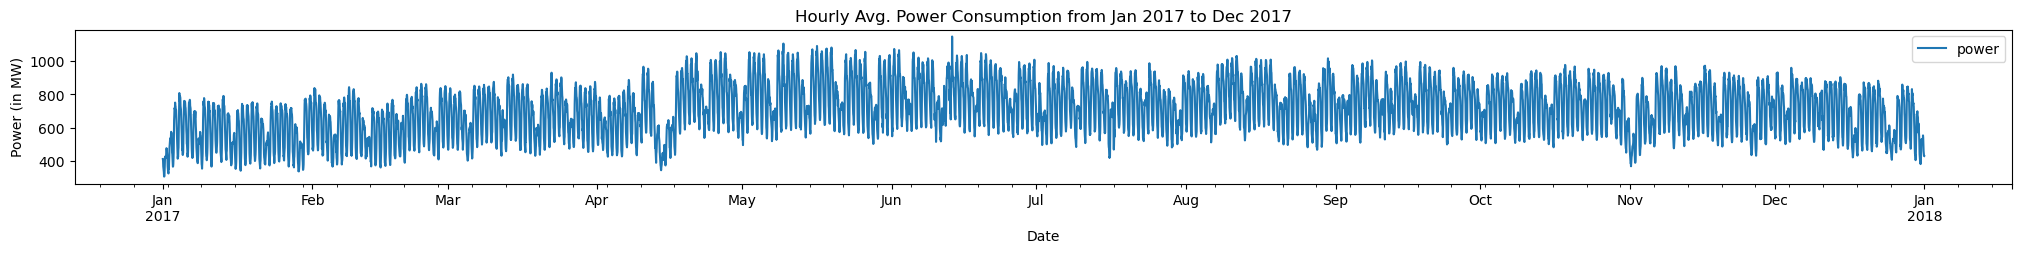

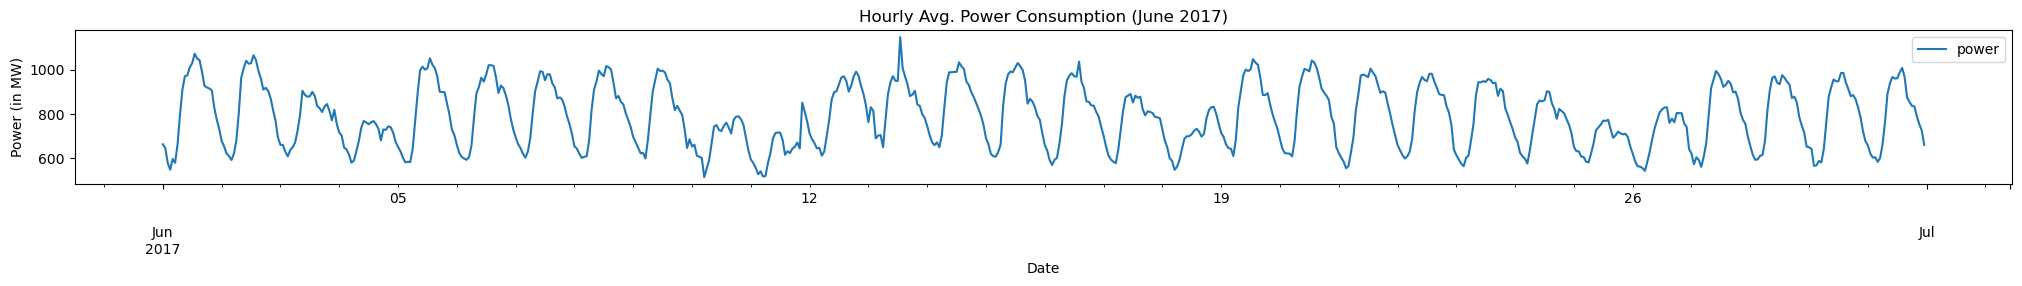

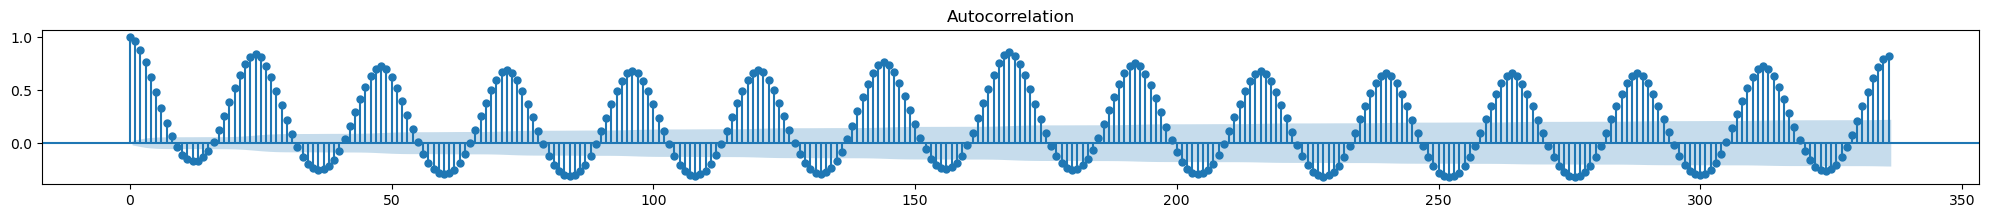

In [4]:
fig, ax = plt.subplots(figsize=(25, 2))
df.plot(title='Hourly Avg. Power Consumption from Jan 2017 to Dec 2017', xlabel='Date', ylabel='Power (in MW)', ax=ax)
plt.autoscale()
plt.show()

fig, ax = plt.subplots(figsize=(25, 2))
df.loc['2017-06'].plot(title='Hourly Avg. Power Consumption (June 2017)', xlabel='Date', ylabel='Power (in MW)', ax=ax)
plt.autoscale()
plt.show()

fig, ax = plt.subplots(figsize=(25, 2))
plot_acf(df, lags=24*7*2, ax=ax)
plt.autoscale()
plt.show()

## Train-Val-Test Split and Normalization

In [5]:
# 80-10-10 split -> 7008, 876, 876
train_end  = '2017-10-19 23:00:00'
val_start  = '2017-10-20 00:00:00'
val_end    = '2017-11-25 11:00:00'
test_start = '2017-11-25 12:00:00'

scaler = StandardScaler().fit(df[:train_end])
df_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
df_scaled.tail()

,power
date,
2017-12-31 19:00:00,-1.362105
2017-12-31 20:00:00,-1.547497
2017-12-31 21:00:00,-1.650493
2017-12-31 22:00:00,-1.729769
2017-12-31 23:00:00,-1.732266


## Windowing

In [6]:
# Create rolling windows
seq_len = 24*7 + 24 + 1 # 168 + 24 + 1 observations

df_windows = pd.concat([df_scaled.shift(+i) for i in range(seq_len)], axis=1).iloc[:, ::-1].dropna() # index is the date of the last observation
df_windows.columns = list(range(seq_len))
df_windows

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
date,,,,,,,,,,,,,,,,,,,,,
2017-01-09 00:00:00,-1.841504,-1.903925,-2.118032,-2.200428,-2.292813,-2.335259,-2.499428,-2.499428,-2.473836,-2.197932,...,-1.280332,-1.214790,-0.828399,-0.834017,-0.949497,-0.963854,-1.104927,-1.405176,-1.581829,-1.808420
2017-01-09 01:00:00,-1.903925,-2.118032,-2.200428,-2.292813,-2.335259,-2.499428,-2.499428,-2.473836,-2.197932,-2.053737,...,-1.214790,-0.828399,-0.834017,-0.949497,-0.963854,-1.104927,-1.405176,-1.581829,-1.808420,-2.038132
2017-01-09 02:00:00,-2.118032,-2.200428,-2.292813,-2.335259,-2.499428,-2.499428,-2.473836,-2.197932,-2.053737,-1.769719,...,-0.828399,-0.834017,-0.949497,-0.963854,-1.104927,-1.405176,-1.581829,-1.808420,-2.038132,-2.086197
2017-01-09 03:00:00,-2.200428,-2.292813,-2.335259,-2.499428,-2.499428,-2.473836,-2.197932,-2.053737,-1.769719,-1.745374,...,-0.834017,-0.949497,-0.963854,-1.104927,-1.405176,-1.581829,-1.808420,-2.038132,-2.086197,-2.204174
2017-01-09 04:00:00,-2.292813,-2.335259,-2.499428,-2.499428,-2.473836,-2.197932,-2.053737,-1.769719,-1.745374,-1.813414,...,-0.949497,-0.963854,-1.104927,-1.405176,-1.581829,-1.808420,-2.038132,-2.086197,-2.204174,-2.015660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-0.081211,-0.199188,-0.396441,-0.746003,-0.920783,-1.259733,-1.358984,-1.405800,-1.621155,-1.623652,...,-1.093067,-1.211669,-1.199808,-1.197312,-1.258485,-1.268472,-1.219783,-0.958861,-1.049372,-1.362105
2017-12-31 20:00:00,-0.199188,-0.396441,-0.746003,-0.920783,-1.259733,-1.358984,-1.405800,-1.621155,-1.623652,-1.558733,...,-1.211669,-1.199808,-1.197312,-1.258485,-1.268472,-1.219783,-0.958861,-1.049372,-1.362105,-1.547497
2017-12-31 21:00:00,-0.396441,-0.746003,-0.920783,-1.259733,-1.358984,-1.405800,-1.621155,-1.623652,-1.558733,-1.608671,...,-1.199808,-1.197312,-1.258485,-1.268472,-1.219783,-0.958861,-1.049372,-1.362105,-1.547497,-1.650493


In [7]:
df_train = df_windows[:train_end]
df_val = df_windows[val_start:val_end]
df_test = df_windows[test_start:]

## PyTorch Dataset and Dataloader

In [8]:
class TSDataset(Dataset):
    def __init__(self, df_windows):
        self.df = df_windows
        self.seq_len = df_windows.shape[1] - 1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor(self.df.iloc[idx, :-1].values, dtype=torch.float).unsqueeze(-1)
        y = torch.tensor(self.df.iloc[idx, 1:].values, dtype=torch.float).unsqueeze(-1)
        return x, y

## Model Building

In [9]:
class AR_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AR_RNN, self).__init__()
        
        # Input feature size
        self.input_size = input_size
        
        # RNN hidden size
        self.hidden_size = hidden_size
        
        # Number of stacked layers
        self.num_layers = num_layers

        # RNN 
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True) # Make sure to set batch_first=True!
        
        # Output Layer
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_output, hn = self.rnn(x)
        y_hat = self.output_layer(rnn_output)
        return y_hat
    
    def forecast(self, x, horizon):
        preds = []
        
        # First forecast
        rnn_output, hn = self.rnn(x)
        y_hat = self.output_layer(hn[-1, ...])
        preds.append(y_hat.squeeze())
        
        # Autoregressive forecast
        for i in range(horizon-1):
            rnn_output, hn = self.rnn(y_hat.unsqueeze(-1), hn)
            y_hat = self.output_layer(hn[-1, ...])
            preds.append(y_hat.squeeze())
            
        return torch.stack(preds)

In [10]:
# Device
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda')

In [11]:
# Hyperparams
epochs = 15
input_size = 1
hidden_size = 64
num_layers = 3
lr = 0.001
batch_size = 64

# Create model
model = AR_RNN(input_size, hidden_size, num_layers)
model.to(dev)

# Loss, optimizer
loss_fn = F.mse_loss
opt = optim.AdamW(model.parameters(), lr=lr)

# Dataloaders
train_ds = TSDataset(df_train) 
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TSDataset(df_val) 
valid_dl = DataLoader(valid_ds, batch_size=1024)

# History
history = {'train_loss': [], 'val_loss': []}

# Training loop
for e in trange(epochs):
    # Train
    model.train()
    for xb, yb in train_dl:
        # Move to device
        xb = xb.to(dev)
        yb = yb.to(dev)
        
        # Forward
        yb_hat = model(xb)

        # Loss
        loss = loss_fn(yb_hat, yb)

        # Backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    # Validation
    model.eval() 
    with torch.no_grad():
        metrics = {'train_loss': 0, 'val_loss': 0}
        for xb, yb in train_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            metrics['train_loss'] += loss_fn(model(xb), yb).item()
            
        for xb, yb in valid_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            metrics['val_loss'] += loss_fn(model(xb), yb).item()
    
    # Metrics
    train_loss = metrics['train_loss']/len(train_dl)
    val_loss = metrics['val_loss']/len(valid_dl)
    print(f'Epoch {e+1}: train_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}')
    
    # History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train_loss = 0.0368, val_loss = 0.0284
Epoch 2: train_loss = 0.0322, val_loss = 0.0246
Epoch 3: train_loss = 0.0280, val_loss = 0.0225
Epoch 4: train_loss = 0.0245, val_loss = 0.0202
Epoch 5: train_loss = 0.0222, val_loss = 0.0187
Epoch 6: train_loss = 0.0202, val_loss = 0.0173
Epoch 7: train_loss = 0.0183, val_loss = 0.0159
Epoch 8: train_loss = 0.0172, val_loss = 0.0155
Epoch 9: train_loss = 0.0163, val_loss = 0.0154
Epoch 10: train_loss = 0.0158, val_loss = 0.0153
Epoch 11: train_loss = 0.0155, val_loss = 0.0151
Epoch 12: train_loss = 0.0152, val_loss = 0.0150
Epoch 13: train_loss = 0.0150, val_loss = 0.0147
Epoch 14: train_loss = 0.0148, val_loss = 0.0145
Epoch 15: train_loss = 0.0146, val_loss = 0.0145


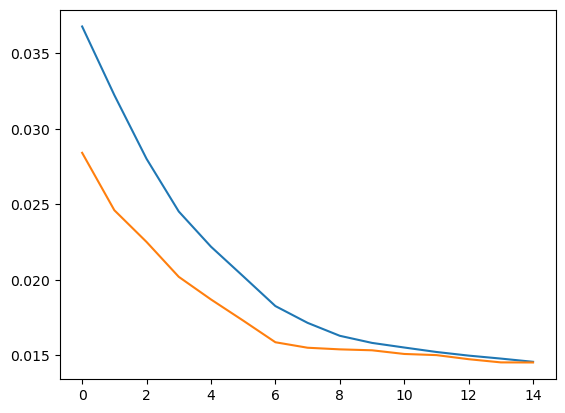

In [12]:
plt.plot(np.array(history['train_loss']))
plt.plot(np.array(history['val_loss']))
plt.show()

## Sample Forecasts

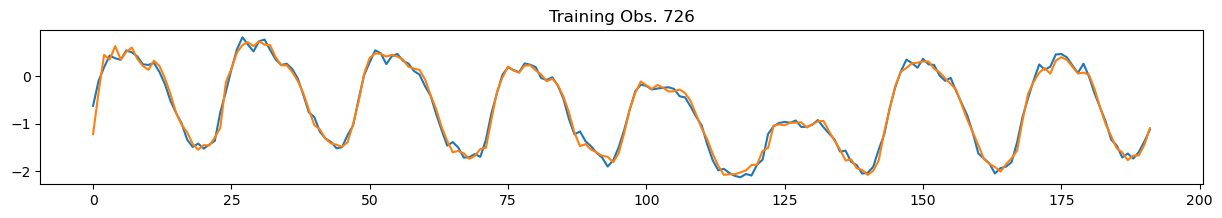

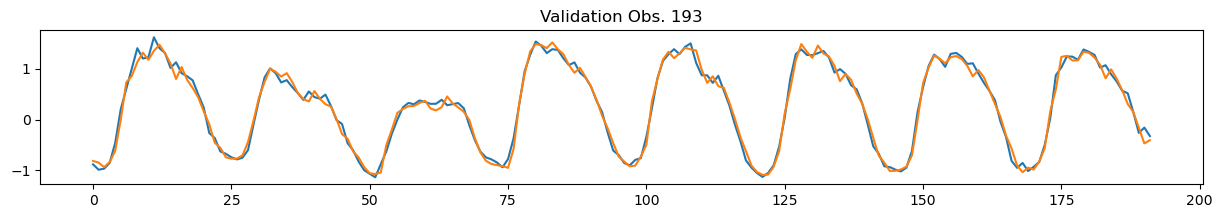

In [13]:
model.eval() 
with torch.no_grad():
    idx = np.random.randint(len(train_ds))
    xb, yb = train_ds[idx:idx+1]
    yb_hat = model(xb.to(dev))

    y_true = yb.squeeze().numpy()
    y_pred = yb_hat.squeeze().cpu().numpy()

    fig, ax = plt.subplots(figsize=(15, 2))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.title(f'Training Obs. {idx}')
    plt.autoscale()
    plt.show()
    
    idx = np.random.randint(len(valid_ds))
    xb, yb = valid_ds[idx:idx+1]
    yb_hat = model(xb.to(dev))

    y_true = yb.squeeze().numpy()
    y_pred = yb_hat.squeeze().cpu().numpy()

    fig, ax = plt.subplots(figsize=(15, 2))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.title(f'Validation Obs. {idx}')
    plt.autoscale()
    plt.show()

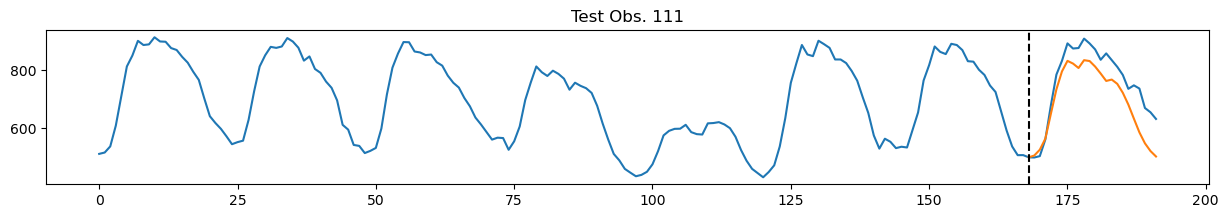

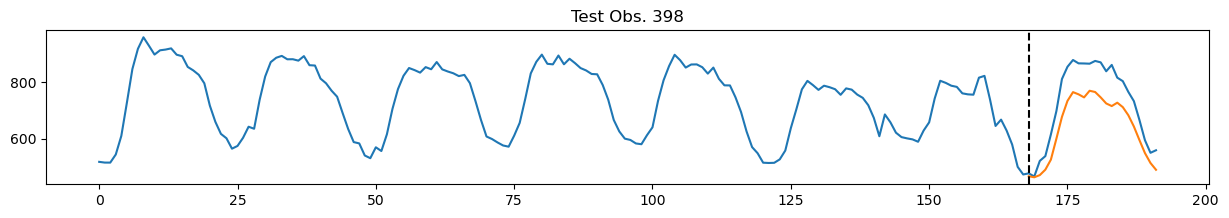

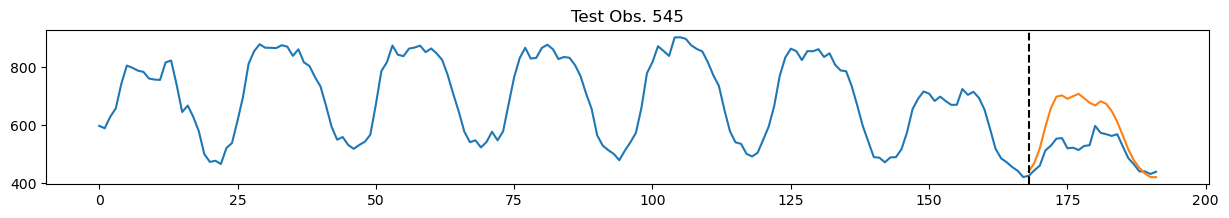

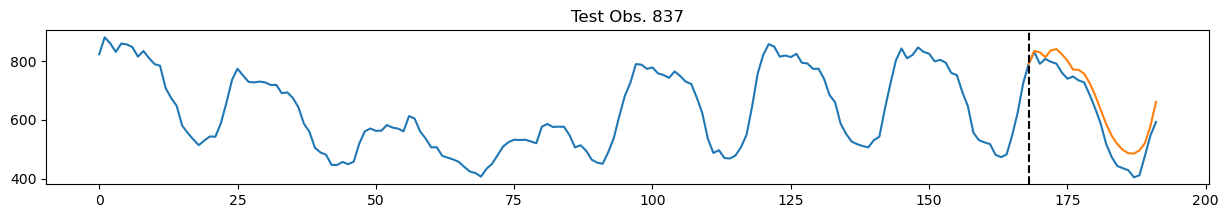

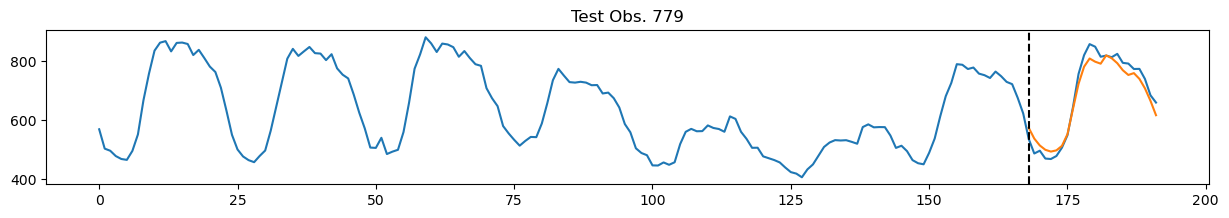

In [49]:
test_ds = TSDataset(df_test)
horizon = 24

model.eval() 
with torch.no_grad():
    for i in range(5):
        idx = np.random.randint(len(test_ds))
        xb, yb = test_ds[idx:idx+1]

        actual = xb.squeeze().numpy()
        y_pred = model.forecast(xb[:, :-horizon, :].to(dev), horizon).cpu().numpy()
        
        actual = scaler.inverse_transform(actual.reshape(-1, 1))
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

        y_range = np.arange(len(actual))
        fig, ax = plt.subplots(figsize=(15, 2))
        plt.plot(y_range, actual)
        plt.plot(y_range[-horizon:], y_pred)
        plt.axvline(len(y_range)-horizon, ls='--', color='black')
        plt.title(f'Test Obs. {idx}')
        plt.autoscale()
        plt.show()

## Metrics

In [64]:
test_dl = DataLoader(test_ds, batch_size=1024)

model.eval() 
with torch.no_grad():
    xb, yb = test_ds[:]
    y_true = xb.squeeze().numpy()[:, -horizon:]
    y_pred = model.forecast(xb[:, :-horizon, :].to(dev), horizon).T.cpu().numpy()
    y_pred_snaive = xb.squeeze().numpy()[:, -horizon*2:-horizon]

    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    y_pred_snaive = scaler.inverse_transform(y_pred_snaive)

In [71]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

pd.DataFrame(
    data=np.array(([mape(y_true, y_pred), mape(y_true, y_pred_snaive)],
                   [mae(y_true, y_pred), mae(y_true, y_pred_snaive)],
                   [mse(y_true, y_pred, squared=False), mse(y_true, y_pred_snaive, squared=False)])),
    columns=['RNN', 'S.Naive'],
    index=['MAPE', 'MAE', 'RMSE']
)

,RNN,S.Naive
MAPE,0.068148,0.099041
MAE,43.404652,65.036751
RMSE,58.650822,90.230446
